In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo, structures
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import torch
import glob

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Liberation Sans'
plt.rcParams.update({'font.size': 16,   # Sets default font size for texts
                     'axes.labelsize': 'large',  # Sets font size for axis labels
                     'axes.titlesize': 'large',  # Sets font size for plot titles
                     'xtick.labelsize': 'medium',  # Sets font size for x-axis tick labels
                     'ytick.labelsize': 'medium',  # Sets font size for y-axis tick labels
                     'legend.fontsize': 'large',  # Sets font size for legend
                     'figure.titlesize': 'large'}) 

In [3]:
# Load some functions and such that are needed
from detectron2.engine import DefaultTrainer
# load model
cfg = get_cfg()
cfg.OUTPUT_DIR = "./Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[02/29 14:02:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./Models/model_final.pth ...


In [8]:
watt=120
extension=f"bt78_{watt}W_28418f"
directory_path=f"/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/{extension}/Images"

bubind_file=f'./Saved_Data/bubind_{extension}.npy'
frameind_file=f'./Saved_Data/frames_{extension}.npy'

In [9]:
# Load data
#bubInd=np.load(f'./Saved_Data/bubind_bt-78-105-1.npy', allow_pickle=True)
#frames=np.load(f'./Saved_Data/frames_bt-78-105-1.npy', allow_pickle=True)
bubInd=np.load(bubind_file, allow_pickle=True)
frames=np.load(frameind_file, allow_pickle=True)

In [11]:
def get_image_paths(directory):
    """
    Get a list of file paths for all image files in the specified directory and its subdirectories.

    Args:
    directory (str): The directory to search for image files.

    Returns:
    List[str]: A list of file paths for all image files found, sorted alphabetically.
    """
    image_extensions = ['*.jpg']  # Add more extensions as needed

    image_paths = []
    for extension in image_extensions:
        pattern = os.path.join(directory, '**', extension)
        image_paths.extend(glob.glob(pattern, recursive=True))

    return sorted(image_paths)  # Sort the list of image paths alphabetically




# Get a list of image file paths sorted alphabetically
image_paths = get_image_paths(directory_path)

# Print the sorted list of image file paths
print(image_paths[0:10])



['/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/bt78_120W_28418f/Images/Img000000.jpg', '/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/bt78_120W_28418f/Images/Img000001.jpg', '/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/bt78_120W_28418f/Images/Img000002.jpg', '/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/bt78_120W_28418f/Images/Img000003.jpg', '/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/bt78_120W_28418f/Images/Img000004.jpg', '/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/bt78_120W_28418f/Images/Img000005.jpg', '/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/bt78_120W_28418f/Images/Img000006.jpg', '/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/bt78_120W_28418f/Images/Img000007.jpg', '/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/bt78_120W_28418f/Images/Img000008.jpg', '/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/bt78_120W_28418f/Images/Img000009.jpg']


In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import PIL.Image
from scipy.spatial import cKDTree
bubble=0
# Set the output video file name
output_file = f'./vel_bubble{bubble}1.avi'
frame_width = 832
frame_height = 600
'''
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, 10, (frame_width, frame_height), isColor=True)
'''
skip=5
angles=[]
#Save Contours of a bubble in each frame
from tqdm import tqdm
import cv2
import numpy as np
image_paths_sub=image_paths[0:]

#output_video = 'bubble0.avi'
#frame_size = (832, 600)
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
#out = cv2.VideoWriter(output_video, fourcc, 20.0, frame_size, isColor=False)
#bubble=12
contours=[]
centroids=[]
values=[]
#for i in tqdm(range(len(frames[bubble]))):
indexs=[]
for i in range(len(frames[bubble])):
    new_im = cv2.imread(image_paths_sub[frames[bubble][i]])
    outputs = predictor(new_im)
    box = outputs["instances"].pred_boxes
    box = box.tensor
    box = box.cpu().tolist()
    masks = outputs["instances"].pred_masks.cpu()
    scores = outputs["instances"].scores
    scores = scores.cpu().tolist()
    k = 0
    for j in range(len(box)):
        x1, y1, x2, y2 = box[j]
        if y2 > -1000:
            if k == bubInd[bubble][i]:
                mask = np.uint8(masks[j]) * 255
                contours1, _=cv2.findContours(mask, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                if len(contours1)>1:
                    largest_contour=max(contours1, key=cv2.contourArea)
                    contours1=np.array(largest_contour).reshape((-1,2))
                else:
                    contours1=np.array(contours1).reshape((-1,2))
                    #out.write(mask)
                contours.append(contours1)
                indexs.append(j)
            k += 1




avg_mag=[]
mag=[]
contour_connections=[]
for j in range(len(frames[bubble]) - skip-1):

    newimg = cv2.imread(image_paths_sub[frames[bubble][j]])

    frame1 = frames[bubble][j]
    frame2 = frames[bubble][j + skip]
    tree_set1 = cKDTree(contours[j + skip])
    distances, indices = tree_set1.query(contours[j], k=1)
    '''
    fig, ax = plt.subplots()
    ax.imshow(newimg)
    ax.scatter(contours[j][:, 0], contours[j][:, 1], label='Set 1', marker='o', s=1)
    ax.scatter(contours[j + skip][:, 0], contours[j + skip][:, 1], label='Set 2', marker='x', s=1)
    '''
    velocitys=(np.array(distances)/184)/((frame2-frame1)/3000)
    distances=velocitys
    avg_mag.append(np.mean(np.array(distances)))
    mag.append(list(distances))
    # Connect the paired points
    ang=[]
    #print(len(contours[j]), len(indices), max(indices))
    '''
    if j ==0:
        values.append(indices[0])
    else:
        values.append(indices[values[-1]])
    '''  
        
    for i in range(0, len(contours[j]), 1):
        point1 = contours[j][i]
        point2 = contours[j + skip][indices[i]]
        vector=point1-point2
        angle_rad=np.arctan2(vector[1],vector[0])
        angle_rad=np.degrees(angle_rad)
        if angle_rad <0:
            angle_rad +=360
        ang.append(angle_rad)
        #ax.arrow(point1[0], point1[1], point2[0] - point1[0], point2[1] - point1[1],
        #         head_width=4, head_length=6, fc='k', ec='k', linewidth=0.5)
    angles.append(ang)
    contour_connections.append(contours[j+skip][indices])


/home/cldunlap/.conda/envs/detectron2_4/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [198]:
direction=[]
for i in range(len(contours)-skip-1):
#for i in range(1):
    new_im = cv2.imread(image_paths_sub[frames[bubble][i]])
    outputs = predictor(new_im)
    masks = outputs["instances"].pred_masks.cpu()
    mask = np.uint8(masks[indexs[i]]) * 255
    class_val=[]
    for j in range(len(contours[i])):
        x_coord=contour_connections[i][j][0]
        y_coord=contour_connections[i][j][1]
        if x_coord >=832:
            x_coord =831
        elif x_coord <=0:
            x_coord=0
                
        if y_coord <=0:
            y_coord=0
        elif y_coord >=600:
            y_coord=599
            
        if mask[y_coord][x_coord]==255:
            class_val.append(1)
        else:
            class_val.append(0)
    direction.append(class_val)
    

In [199]:
for i in range(len(direction)):
    for j in range(len(direction[i])):
        if direction[i][j]==1:
            mag[i][j] = mag[i][j] *-1

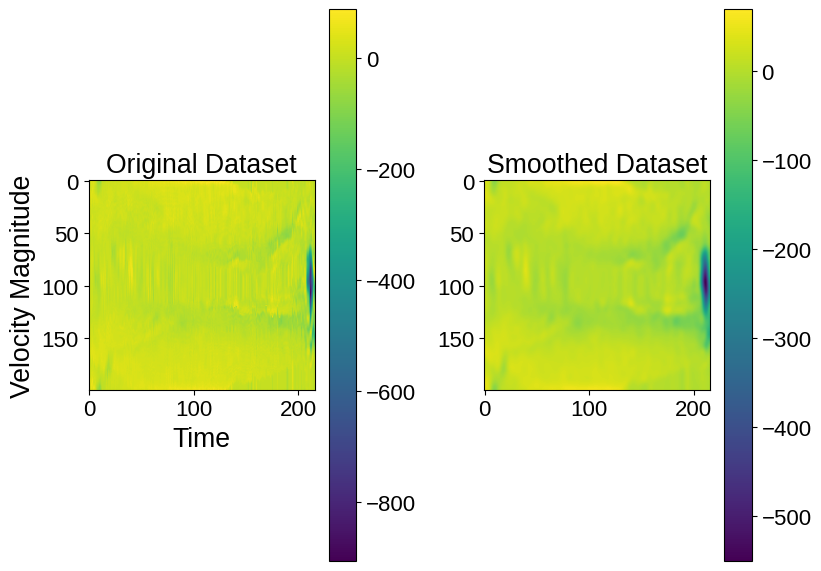

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftfreq
from scipy.ndimage import gaussian_filter

length=len(mag[0])
for i in range(len(mag)):
    if len(mag[i]) <= length:
        length=len(mag[i])
        
num_entries = 200
data=np.empty((len(mag), num_entries))
# Calculate indices for evenly spaced entries
for i in range(len(mag)):
    indices = np.linspace(0, len(mag[i]) - 1, num_entries, dtype=int)
    data[i:]=np.array(mag[i])[indices]
#data=data[:-20]

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original Dataset")
plt.imshow(data.T, cmap='viridis')
plt.xlabel('Time')
plt.ylabel('Velocity Magnitude')
plt.colorbar()

plt.subplot(1, 3, 2)
data_smoothed = gaussian_filter(data, sigma=2)
plt.title("Smoothed Dataset")
plt.imshow(data_smoothed.T, cmap='viridis')
plt.colorbar()
'''
plt.subplot(1, 3, 3)
data_fft = fft2(data_smoothed)
freq_x = fftfreq(data.shape[0], d=(x[-1]-x[0])/len(x))
freq_y = fftfreq(data.shape[1], d=(y[-1]-y[0])/len(y))
freq_x, freq_y = np.meshgrid(freq_x, freq_y)
plt.title("2D Fourier Transform")
plt.imshow(np.abs(np.fft.fftshift(data_fft)), cmap='viridis', extent=(freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()))
plt.colorbar()
'''
plt.tight_layout()
plt.show()


In [201]:
data1=np.empty((len(mag), num_entries))
#data1=data1[:-20]
split_val=100
data1[:,0:-split_val]=data[:,split_val:]
data1[:,-split_val:]=data[:,0:split_val]
#data1=data

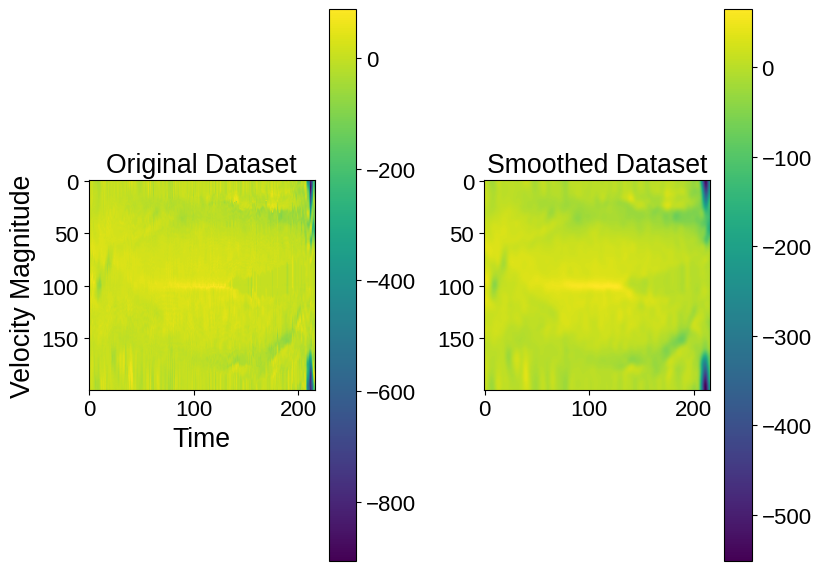

In [202]:
data=data1

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original Dataset")
plt.imshow(data.T, cmap='viridis')
plt.xlabel('Time')
plt.ylabel('Velocity Magnitude')
plt.colorbar()

plt.subplot(1, 3, 2)
data_smoothed = gaussian_filter(data, sigma=2)
plt.title("Smoothed Dataset")
plt.imshow(data_smoothed.T, cmap='viridis')
plt.colorbar()
'''
plt.subplot(1, 3, 3)
data_fft = fft2(data_smoothed)
freq_x = fftfreq(data.shape[0], d=(x[-1]-x[0])/len(x))
freq_y = fftfreq(data.shape[1], d=(y[-1]-y[0])/len(y))
freq_x, freq_y = np.meshgrid(freq_x, freq_y)
plt.title("2D Fourier Transform")
plt.imshow(np.abs(np.fft.fftshift(data_fft)), cmap='viridis', extent=(freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()))
plt.colorbar()

'''
plt.tight_layout()
plt.show()


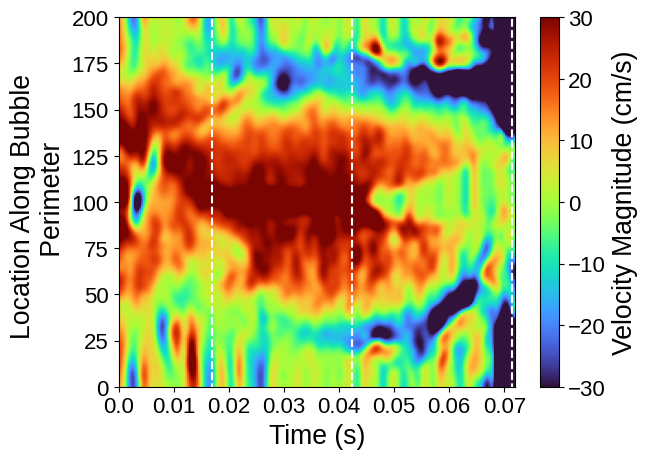

In [230]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data
total_time=len(data)/3000
# Plot the data with a color bar

image=plt.imshow(data_smoothed.T,extent=[0,total_time,0,200], aspect='auto', cmap='turbo', alpha=1)
cbar = plt.colorbar()
cbar.set_label('Velocity Magnitude (cm/s)')  # Set label for the color bar
image.set_clim(vmin=-30, vmax=30)  # Set the range of values to display
plt.plot([51/3000,51/3000],[199,0],'--',color='white')
plt.plot([127/3000,127/3000],[199,0],'--',color='white')
plt.plot([214/3000,214/3000],[199,0],'--',color='white')
plt.xticks(np.arange(0, total_time, 0.01), [str(i) for i in np.arange(0, total_time, 0.01)])

plt.xlabel('Time (s)')
plt.ylabel('Location Along Bubble \n Perimeter')
# Control the range of values displayed on the color bar

plt.show()


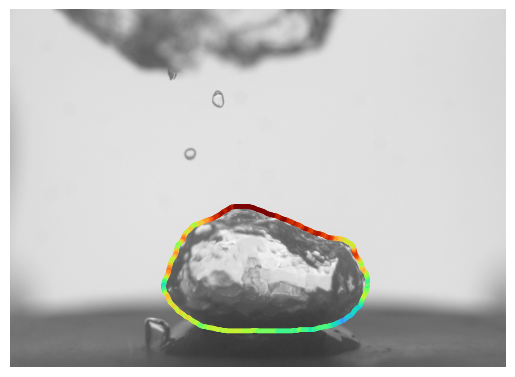

In [232]:
import numpy as np
import matplotlib.pyplot as plt

val=51
plt.imshow(cv2.imread(image_paths_sub[frames[bubble][val]]), alpha=0.9)
# Create a scatter plot and use the colors vector for coloring
plt.scatter(contours[val][:,0],contours[val][:,1], c=mag[val],vmin=-30,vmax=30, s=5,cmap='turbo')

# Add color bar to show the mapping between colors and values
#plt.colorbar(label='Values')  # Label for the color bar
#plt.plot(contours[val+1][:,0],contours[val+1][:,1],color='black')

plt.axis('off')

plt.show()


In [98]:
num_entries = 200
contourx=np.empty( num_entries)
contoury=np.empty( num_entries)

# Calculate indices for evenly spaced entries
indices = np.linspace(0, len(contours[val][:,]) - 1, num_entries, dtype=int)
contourx=np.array(contours[val][:,0])[indices]
contoury=np.array(contours[val][:,1])[indices]

contoury1=np.empty(len(contoury))
#data1=data1[:-20]
split_val=100
contoury1[0:-split_val]=contoury[split_val:]
contoury1[-split_val:]=contoury[0:split_val]
#data1=data

contourx1=np.empty(len(contourx))
#data1=data1[:-20]
split_val=100
contourx1[0:-split_val]=contourx[split_val:]
contourx1[-split_val:]=contourx[0:split_val]
#data1=data

NameError: name 'contourx1' is not defined

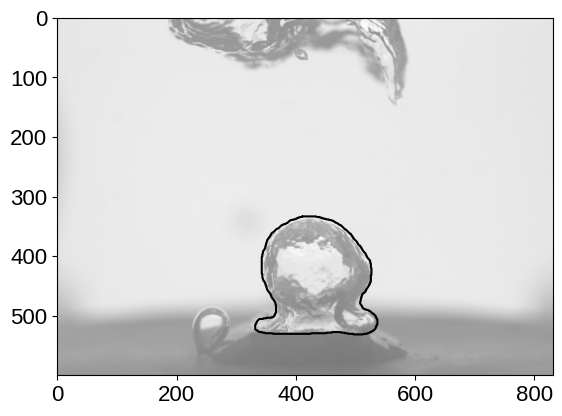

In [13]:
import numpy as np
import matplotlib.pyplot as plt

val=110
plt.imshow(cv2.imread(image_paths_sub[frames[bubble][val]]),alpha=0.6)
# Create a scatter plot and use the colors vector for coloring

# Add color bar to show the mapping between colors and values
#plt.colorbar(label='Values')  # Label for the color bar
plt.plot(contours[val+1][:,0],contours[val+1][:,1],color='black')
#for i in range(len(contours[val+1])):

points=[0,25,50,75,100,125,150,175]
labels=['a','b','c','d','e','f','g','h']
driftsx=[0,10,10,5,-20,-40,-60,-30]
driftsy=[30,30,5,-5,-10,10,10,30]
for i in range(len(points)):
    plt.text(contourx1[points[i]]+driftsx[i],contoury1[points[i]]+driftsy[i], labels[i], fontsize=12)
    plt.scatter(contourx1[points[i]],contoury1[points[i]],marker='s',c='black',s=10)

plt.axis('off')

plt.show()


In [8]:
image_paths_sub=image_paths[0:]


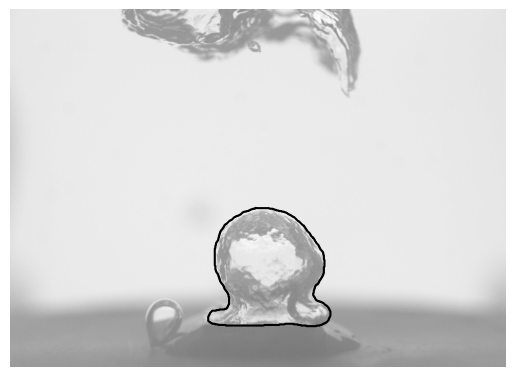

In [163]:
import numpy as np
import matplotlib.pyplot as plt

val=110
plt.imshow(cv2.imread(image_paths_sub[frames[bubble][val]]),alpha=0.6)
# Create a scatter plot and use the colors vector for coloring

# Add color bar to show the mapping between colors and values
#plt.colorbar(label='Values')  # Label for the color bar
plt.plot(contours[val+1][:,0],contours[val+1][:,1],color='black')

plt.axis('off')

plt.show()

In [149]:
num_entries = 200
mag2=np.empty( num_entries)
# Calculate indices for evenly spaced entries
indices = np.linspace(0, len(mag[val]) - 1, num_entries, dtype=int)
mag2=np.array(mag[val])[indices]

mag1=np.empty(len(mag2))
#data1=data1[:-20]
split_val=100
mag1[0:-split_val]=mag2[split_val:]
mag1[-split_val:]=mag2[0:split_val]
#data1=data

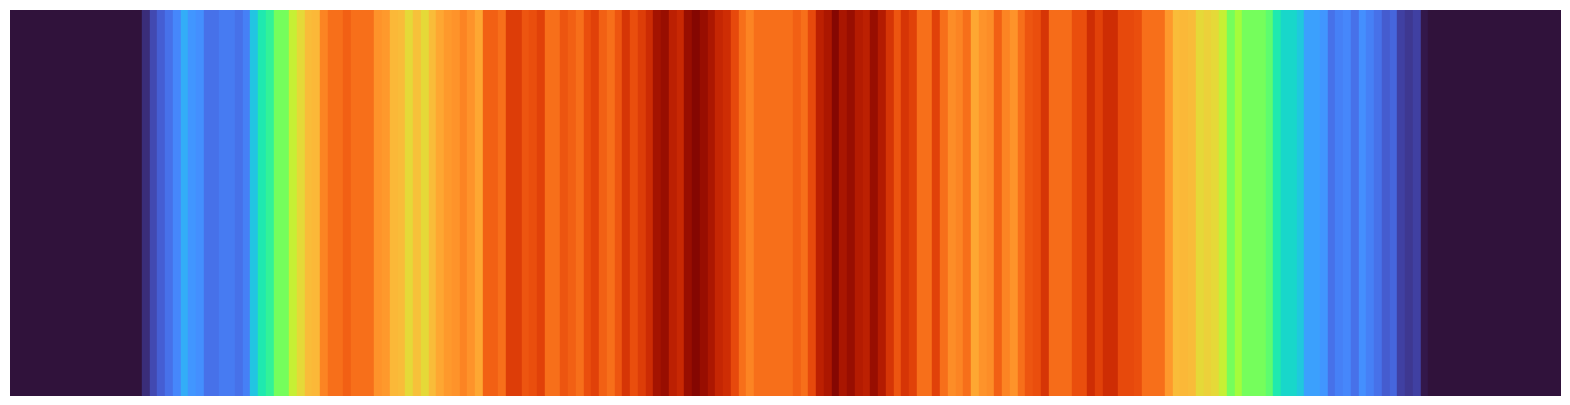

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Array of magnitudes
magnitudes = mag1 # Example magnitudes

# Define the range for the colormap
min_value = -30
max_value = 30

# Normalize magnitudes within the specified range
norm = Normalize(vmin=min_value, vmax=max_value)

# Colormap
cmap = plt.cm.turbo  # Example colormap

# ScalarMappable to map magnitudes to colors using cmap
sm = ScalarMappable(norm=norm, cmap=cmap)

# Define the segments of the rectangle
segments = len(magnitudes)

# Define the figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
# Plot each segment with its corresponding color
for i in range(segments):
    ax.fill_between([i, i + 1], 0, 1, color=sm.to_rgba(magnitudes[i]), alpha=1)

# Set limits and labels
ax.set_xlim(0, segments)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0.5, segments, 1))
ax.set_xticklabels(magnitudes)
plt.axis('off')
# Set title and labels

# Add colorbar
#cbar = plt.colorbar(sm)
#cbar.set_label('Magnitude')

# Show the plot
plt.show()


/tmp/ipykernel_1517879/3207974240.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


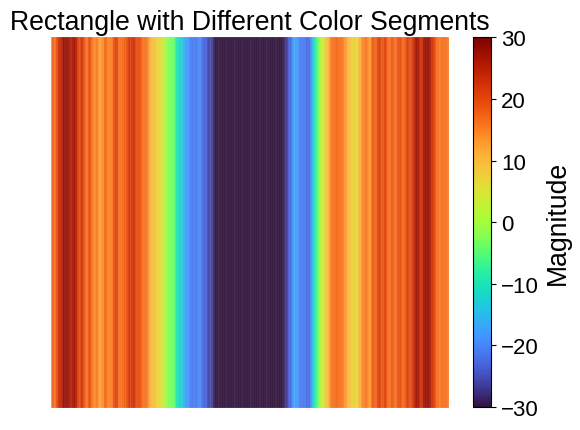

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Array of magnitudes
magnitudes = mag[val] # Example magnitudes

# Define the range for the colormap
min_value = -30
max_value = 30

# Normalize magnitudes within the specified range
norm = Normalize(vmin=min_value, vmax=max_value)

# Colormap
cmap = plt.cm.turbo  # Example colormap

# ScalarMappable to map magnitudes to colors using cmap
sm = ScalarMappable(norm=norm, cmap=cmap)

# Define the segments of the rectangle
segments = len(magnitudes)

# Define the figure and axis
fig, ax = plt.subplots()

# Plot each segment with its corresponding color
for i in range(segments):
    ax.fill_between([i, i + 1], 0, 1, color=sm.to_rgba(magnitudes[i]), alpha=0.5)

# Set limits and labels
ax.set_xlim(0, segments)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0.5, segments, 1))
ax.set_xticklabels(magnitudes)
plt.axis('off')
# Set title and labels
plt.title('Rectangle with Different Color Segments')
plt.xlabel('Magnitude')
plt.ylabel('Value')

# Add colorbar
cbar = plt.colorbar(sm)
cbar.set_label('Magnitude')

# Show the plot
plt.show()
